In [ ]:
!pip install segmentation_models


# New section

In [ ]:
!unzip images.zip
!unzip mask.zip


Archive:  images.zip
   creating: images/
  inflating: images/download (1).jpg  
  inflating: images/download (10).jpg  
  inflating: images/download (11).jpg  
  inflating: images/download (2).jpg  
  inflating: images/download (20).jpg  
  inflating: images/download (21).jpg  
  inflating: images/download (22).jpg  
  inflating: images/download (23).jpg  
  inflating: images/download (24).jpg  
  inflating: images/download (25).jpg  
  inflating: images/download (27).jpg  
  inflating: images/download (28).jpg  
  inflating: images/download (3).jpg  
  inflating: images/download (30).jpg  
  inflating: images/download (31).jpg  
  inflating: images/download (32).jpg  
  inflating: images/download (36).jpg  
  inflating: images/download (40).jpg  
  inflating: images/download (41).jpg  
  inflating: images/download (42).jpg  
  inflating: images/download (43).jpg  
  inflating: images/download (44).jpg  
  inflating: images/download (46).jpg  
  inflating: images/download (47).jpg  
 

In [ ]:
!pip install keras

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ouzi5ibv
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ouzi5ibv
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=583d6628a0811ee475eded6542a8fba5390a93d665c3817f8338d6fde1514b1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlu0830g/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [163]:

import glob
import cv2
import os 
import numpy as np
import tensorflow as tf
from  tensorflow.keras.preprocessing.image import ImageDataGenerator

dir_img = "images/"
dir_mask = "mask/"


x = np.zeros((324, 128, 128, 3),dtype=np.float32)
y = np.zeros((324, 128, 128, 1),dtype=np.float32)

img_files = glob.glob(dir_img+"*.jpg")
mask_files = glob.glob(dir_mask+"*.png")
#print(img_files)
#print("hello",len(img_files))

for i in range(len(img_files)):
    img_temp=cv2.imread(img_files[i], 1)
    img_temp=cv2.resize(img_temp,(128,128))
    x[i, :, :, :] = img_temp.copy()
    #print(x[i,:,:,:].dtype)
    temp = cv2.imread(mask_files[i], 0)
    temp=cv2.resize(temp,(128,128))
    temp = temp > 200
    y[i,:,:,0] = temp.copy()


index = np.random.permutation(324)


xtrain = x[index[:300], :,:,:]
ytrain = y[index[:300], :,:,:]

xval = x[index[300:], :,:,:]
yval = y[index[300:], :,:,:]


%env SM_FRAMEWORK=tf.keras



from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

BACKBONE = 'efficientnetb0'
preprocess_input = get_preprocessing(BACKBONE)

#load your data
#xtrain, ytrain, xval, yval = load_data(...)

 #preprocess input
xtrain = preprocess_input(xtrain)
xval = preprocess_input(xval)

# define model
model = Unet('efficientnetb0', encoder_weights='imagenet')
model.compile('Adam', loss=bce_jaccard_loss, metrics=["accuracy"])
print(xtrain.shape,ytrain.shape)
checkpoint_filepath = "checkpoint/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)
datagen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,vertical_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
x_data=datagen.flow(xtrain,ytrain)
#model.summary()
# fit model
x=model.fit(x_data,epochs=300,validation_data=(xval, yval),callbacks=model_checkpoint_callback)


env: SM_FRAMEWORK=tf.keras
(300, 128, 128, 3) (300, 128, 128, 1)
Epoch 1/300
10/10 [==============================] - 11s 308ms/step - loss: 2.0267 - accuracy: 0.1928 - val_loss: 1.7881 - val_accuracy: 0.8193
Epoch 2/300
10/10 [==============================] - 2s 170ms/step - loss: 1.6199 - accuracy: 0.5635 - val_loss: 3.2911 - val_accuracy: 0.8846
Epoch 3/300
10/10 [==============================] - 2s 173ms/step - loss: 1.4623 - accuracy: 0.7652 - val_loss: 54.6883 - val_accuracy: 0.1114
Epoch 4/300
10/10 [==============================] - 2s 186ms/step - loss: 1.3473 - accuracy: 0.8350 - val_loss: 125.7112 - val_accuracy: 0.1103
Epoch 5/300
10/10 [==============================] - 2s 175ms/step - loss: 1.2965 - accuracy: 0.8451 - val_loss: 18.3997 - val_accuracy: 0.1429
Epoch 6/300
10/10 [==============================] - 2s 189ms/step - loss: 1.2599 - accuracy: 0.8365 - val_loss: 22.6925 - val_accuracy: 0.1379
Epoch 7/300
10/10 [==============================] - 2s 176ms/step - lo

In [164]:
score=model.evaluate(xval,yval)
print("test loss ",score[0])
print("test accuracy",score[1])

1/1 [==============================] - 0s 62ms/step - loss: 1.8355 - accuracy: 0.7974
test loss  1.835466742515564
test accuracy 0.7974370121955872


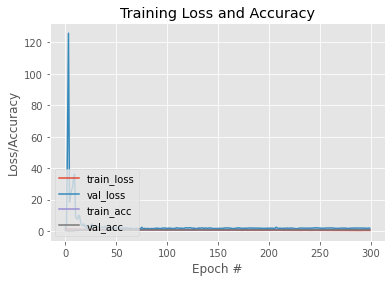

In [169]:
N = 300
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), x.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), x.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), x.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), x.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[1.15794176e-03]
   [4.78183902e-05]
   [2.10698017e-05]
   ...
   [2.52415717e-04]
   [5.01929899e-04]
   [3.52690602e-03]]

  [[6.91929963e-05]
   [1.32428761e-06]
   [7.89596811e-07]
   ...
   [4.88880796e-05]
   [1.06693675e-04]
   [6.51715614e-04]]

  [[2.64146602e-05]
   [4.27507047e-07]
   [3.84327848e-07]
   ...
   [2.63436195e-05]
   [6.90658999e-05]
   [3.41877632e-04]]

  ...

  [[8.02148061e-05]
   [4.13964062e-06]
   [4.86218687e-06]
   ...
   [1.58499839e-04]
   [3.36309196e-04]
   [6.37771736e-04]]

  [[2.42545968e-04]
   [1.77717720e-05]
   [2.47871194e-05]
   ...
   [1.54506357e-04]
   [3.89855210e-04]
   [9.49569454e-04]]

  [[2.63765454e-03]
   [3.33848933e-04]
   [2.06740777e-04]
   ...
   [5.66598901e-04]
   [1.02681841e-03]
   [4.31765569e-03]]]] fst
[[[[1.2647213e-03]
   [5.8707650e-05]
   [2.4858276e-05]
   ...
   [2.3004193e-04]
   [4.4416040e-04]
   [3.4305525e-03]]

  [[7.3895411e-05]
   [1.6865758e-06]
   [9.5834321e-07]
   ...
   [5.8124129e-05]
   [1.09

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[1.68074877e-03]
   [9.10834642e-05]
   [3.97013864e-05]
   ...
   [2.57896422e-03]
   [2.29353784e-03]
   [1.04016662e-02]]

  [[1.16321942e-04]
   [3.58523175e-06]
   [2.28947556e-06]
   ...
   [4.47074359e-04]
   [5.59421547e-04]
   [2.15183361e-03]]

  [[4.96230714e-05]
   [1.36645531e-06]
   [1.22256961e-06]
   ...
   [5.51731791e-05]
   [1.80166739e-04]
   [9.80012002e-04]]

  ...

  [[7.13820860e-04]
   [1.17441385e-04]
   [1.83406606e-04]
   ...
   [4.03181475e-04]
   [3.68641136e-04]
   [6.16153586e-04]]

  [[1.51714729e-03]
   [2.81766377e-04]
   [3.40858183e-04]
   ...
   [3.25967121e-04]
   [8.96842335e-04]
   [1.36048545e-03]]

  [[6.83261454e-03]
   [1.36055029e-03]
   [1.14221999e-03]
   ...
   [1.63674471e-03]
   [2.76353862e-03]
   [7.41768861e-03]]]] fst
[[[[1.1394146e-03]
   [4.6266341e-05]
   [2.0487223e-05]
   ...
   [3.2169191e-04]
   [5.9798645e-04]
   [3.7106273e-03]]

  [[6.8501082e-05]
   [1.2766218e-06]
   [7.6638162e-07]
   ...
   [8.6937100e-05]
   [1.30

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: Runti

[[[[1.13009941e-03]
   [4.60654119e-05]
   [2.03948621e-05]
   ...
   [8.56485218e-04]
   [1.17138936e-03]
   [6.04086742e-03]]

  [[6.77929420e-05]
   [1.25300346e-06]
   [7.44182330e-07]
   ...
   [2.25862314e-04]
   [2.55372113e-04]
   [1.02706789e-03]]

  [[2.54395327e-05]
   [4.11290671e-07]
   [3.61817797e-07]
   ...
   [2.15281198e-05]
   [6.37471458e-05]
   [3.98031494e-04]]

  ...

  [[5.72243764e-04]
   [1.03147264e-04]
   [1.72342814e-04]
   ...
   [1.66925049e-04]
   [2.02660507e-04]
   [4.19448363e-04]]

  [[1.15019036e-03]
   [1.92746898e-04]
   [2.09877893e-04]
   ...
   [1.22391357e-04]
   [4.23544843e-04]
   [8.66840768e-04]]

  [[5.98037010e-03]
   [1.08551153e-03]
   [9.24967462e-04]
   ...
   [5.80759719e-04]
   [1.28877885e-03]
   [4.74502658e-03]]]] fst
[[[[1.1981712e-03]
   [5.2679094e-05]
   [2.3157136e-05]
   ...
   [1.5576700e-04]
   [3.3227561e-04]
   [3.3787442e-03]]

  [[7.0661234e-05]
   [1.4590812e-06]
   [8.3057529e-07]
   ...
   [1.9220879e-05]
   [5.51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[1.1383785e-03]
   [4.8646987e-05]
   [2.1364012e-05]
   ...
   [1.8534217e-04]
   [3.9272296e-04]
   [3.6037848e-03]]

  [[6.5192333e-05]
   [1.2767265e-06]
   [7.1580490e-07]
   ...
   [2.6854581e-05]
   [7.1268529e-05]
   [6.7404145e-04]]

  [[2.3079112e-05]
   [3.7201019e-07]
   [2.9686012e-07]
   ...
   [1.5642370e-05]
   [4.8162678e-05]
   [3.7119235e-04]]

  ...

  [[4.4959562e-04]
   [4.6402169e-05]
   [4.6454457e-05]
   ...
   [3.7933576e-05]
   [7.0520480e-05]
   [2.7068943e-04]]

  [[7.6282868e-04]
   [8.0126498e-05]
   [4.8788177e-05]
   ...
   [6.3541098e-05]
   [2.5467112e-04]
   [7.3927903e-04]]

  [[4.7269110e-03]
   [6.1055651e-04]
   [5.2527111e-04]
   ...
   [4.7490658e-04]
   [1.1693633e-03]
   [4.5076287e-03]]]] fst
[[[[1.3731087e-03]
   [7.4899348e-05]
   [3.4591641e-05]
   ...
   [1.7301377e-04]
   [3.6244612e-04]
   [3.5345927e-03]]

  [[9.8145996e-05]
   [3.2777461e-06]
   [2.0431630e-06]
   ...
   [2.4790215e-05]
   [6.1680126e-05]
   [5.7084137e-04]]

  [[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[1.25959888e-03]
   [5.77129285e-05]
   [2.55203995e-05]
   ...
   [1.86669669e-04]
   [3.87356296e-04]
   [3.83003778e-03]]

  [[7.49199971e-05]
   [1.64727703e-06]
   [9.42305689e-07]
   ...
   [2.44873936e-05]
   [7.03379337e-05]
   [7.58298556e-04]]

  [[2.67787054e-05]
   [4.91311994e-07]
   [3.92179828e-07]
   ...
   [1.75628011e-05]
   [5.38079657e-05]
   [4.70227882e-04]]

  ...

  [[3.87445121e-04]
   [4.81425668e-05]
   [5.60323642e-05]
   ...
   [1.13459835e-04]
   [1.62076860e-04]
   [4.88322170e-04]]

  [[7.23558944e-04]
   [9.18150254e-05]
   [5.92666111e-05]
   ...
   [1.07036161e-04]
   [4.10582492e-04]
   [1.04894245e-03]]

  [[4.12111823e-03]
   [5.86669252e-04]
   [4.61519201e-04]
   ...
   [5.69602649e-04]
   [1.31345238e-03]
   [5.08813886e-03]]]] fst
[[[[1.92463049e-03]
   [1.39214375e-04]
   [8.29594501e-05]
   ...
   [1.90385734e-03]
   [2.21187482e-03]
   [1.02687916e-02]]

  [[1.70588857e-04]
   [1.16693409e-05]
   [1.32407295e-05]
   ...
   [4.12359805e-04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[1.51180290e-03]
   [9.09216178e-05]
   [4.33094974e-05]
   ...
   [8.67708470e-04]
   [1.40599208e-03]
   [7.58296205e-03]]

  [[1.05909108e-04]
   [4.29718193e-06]
   [3.04531727e-06]
   ...
   [4.29632346e-04]
   [6.55556680e-04]
   [2.64327019e-03]]

  [[4.58429204e-05]
   [1.95307621e-06]
   [2.32441857e-06]
   ...
   [4.40384756e-04]
   [6.72353432e-04]
   [2.07509589e-03]]

  ...

  [[5.05227246e-04]
   [8.11800128e-05]
   [1.19609751e-04]
   ...
   [1.03893835e-04]
   [1.63649194e-04]
   [5.94806625e-04]]

  [[9.83037171e-04]
   [1.66840866e-04]
   [1.50735053e-04]
   ...
   [1.29704902e-04]
   [4.52402775e-04]
   [1.29513384e-03]]

  [[5.34339575e-03]
   [9.78449360e-04]
   [8.27735930e-04]
   ...
   [6.88825327e-04]
   [1.48625718e-03]
   [5.93176391e-03]]]] fst
[[[[1.4968850e-03]
   [9.6454780e-05]
   [5.1808544e-05]
   ...
   [6.1225722e-04]
   [1.0424556e-03]
   [6.4085200e-03]]

  [[1.2136804e-04]
   [5.5766368e-06]
   [5.8920000e-06]
   ...
   [1.9165229e-04]
   [2.99

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[1.18980568e-03]
   [5.14434396e-05]
   [2.25103195e-05]
   ...
   [1.90912353e-04]
   [4.01256053e-04]
   [3.72120482e-03]]

  [[6.98992953e-05]
   [1.41338512e-06]
   [8.02990883e-07]
   ...
   [2.66616935e-05]
   [7.49660830e-05]
   [7.21442455e-04]]

  [[2.57078009e-05]
   [4.35658336e-07]
   [3.61458774e-07]
   ...
   [1.90058508e-05]
   [5.58284082e-05]
   [4.37573559e-04]]

  ...

  [[1.17682724e-03]
   [1.22979574e-04]
   [8.69158757e-05]
   ...
   [2.62004972e-01]
   [1.57839552e-01]
   [1.22420624e-01]]

  [[1.85179594e-03]
   [1.79377224e-04]
   [1.00071644e-04]
   ...
   [1.03291206e-01]
   [9.77825820e-02]
   [8.50723162e-02]]

  [[1.04099596e-02]
   [1.68917247e-03]
   [1.25707290e-03]
   ...
   [7.86489323e-02]
   [7.82496631e-02]
   [9.81314704e-02]]]] fst
[[[[1.99131994e-03]
   [1.56303809e-04]
   [1.02753300e-04]
   ...
   [4.45677637e-04]
   [8.72839009e-04]
   [5.20394929e-03]]

  [[1.82588439e-04]
   [1.46157499e-05]
   [1.84949913e-05]
   ...
   [1.18684373e-04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[1.2909380e-03]
   [6.3065767e-05]
   [2.6884227e-05]
   ...
   [4.8222655e-04]
   [8.8747841e-04]
   [5.4540779e-03]]

  [[7.4194584e-05]
   [1.8678111e-06]
   [1.0542699e-06]
   ...
   [1.4499713e-04]
   [2.3591888e-04]
   [9.7216223e-04]]

  [[2.5582389e-05]
   [5.0856585e-07]
   [4.0692530e-07]
   ...
   [3.4852928e-05]
   [8.8882465e-05]
   [4.9923063e-04]]

  ...

  [[6.3453231e-04]
   [9.1487709e-05]
   [1.1419325e-04]
   ...
   [6.6606299e-05]
   [1.2343295e-04]
   [4.3299142e-04]]

  [[1.2186586e-03]
   [1.8551508e-04]
   [1.3760490e-04]
   ...
   [1.1024715e-04]
   [4.1252925e-04]
   [1.1504776e-03]]

  [[7.1745613e-03]
   [1.5662460e-03]
   [1.3148148e-03]
   ...
   [1.0752615e-03]
   [2.2200900e-03]
   [7.0315800e-03]]]] fst
[[[[1.54007284e-03]
   [9.17420257e-05]
   [4.34820286e-05]
   ...
   [1.32653257e-03]
   [1.41454709e-03]
   [6.81664562e-03]]

  [[1.03835591e-04]
   [3.83695306e-06]
   [2.84671660e-06]
   ...
   [3.68366746e-04]
   [3.65564367e-04]
   [1.35292357

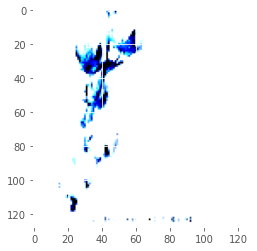

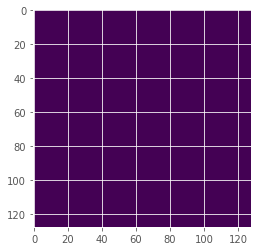

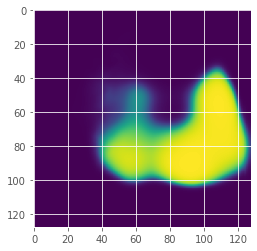

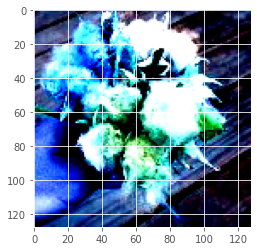

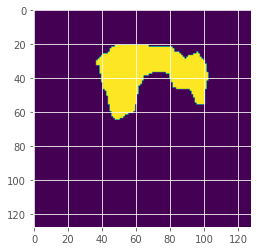

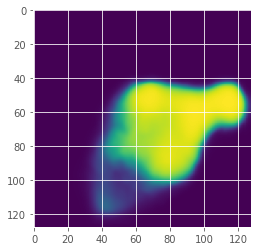

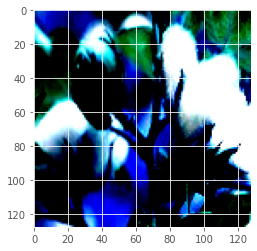

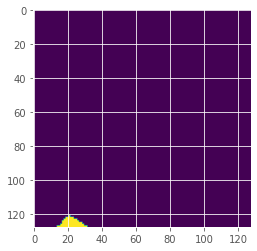

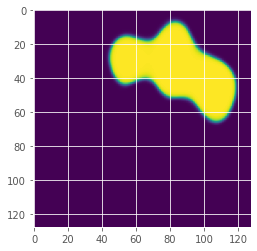

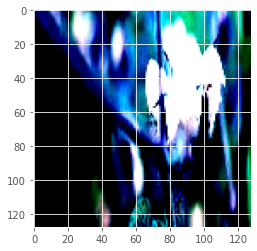

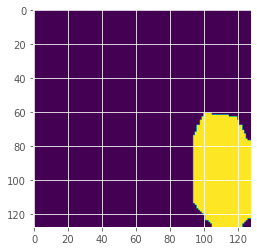

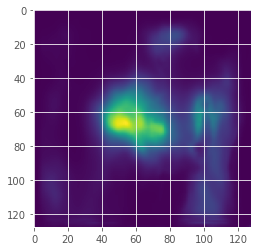

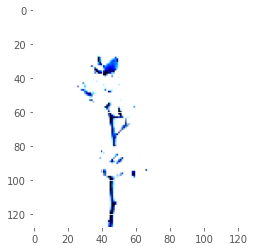

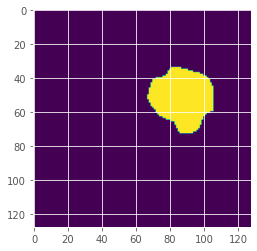

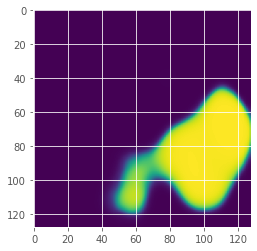

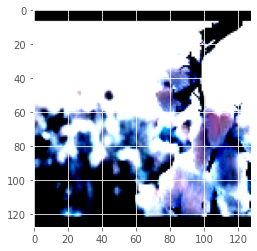

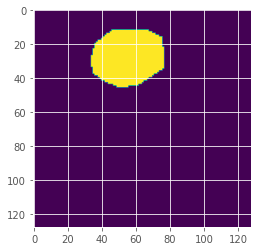

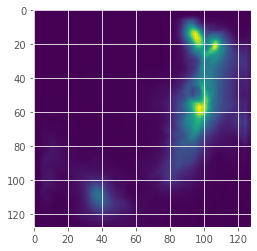

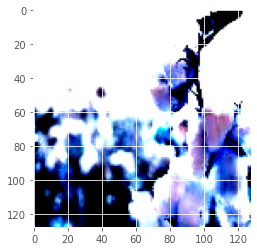

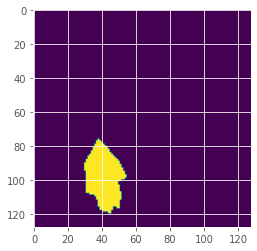

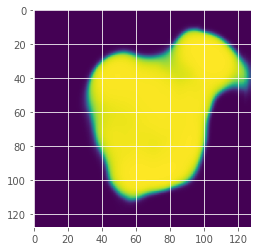

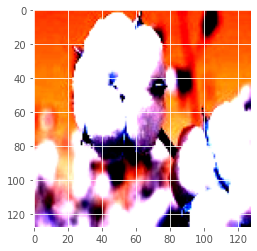

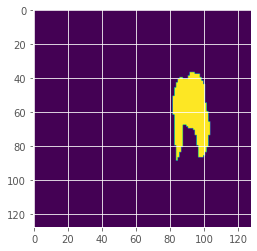

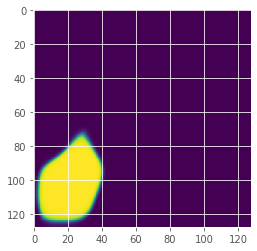

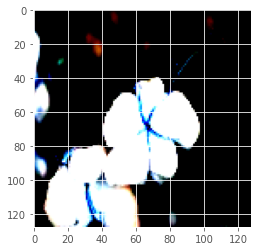

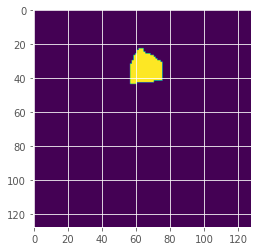

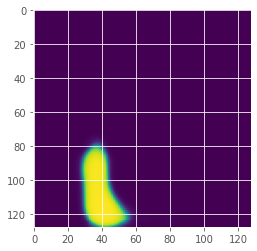

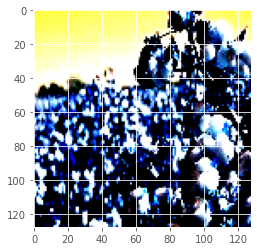

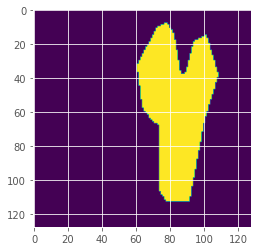

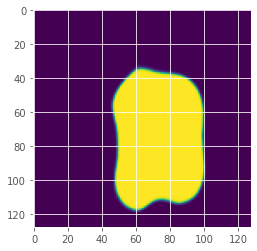

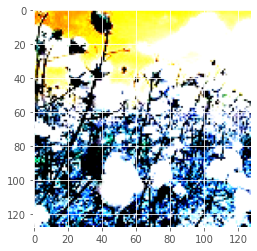

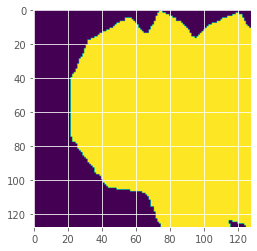

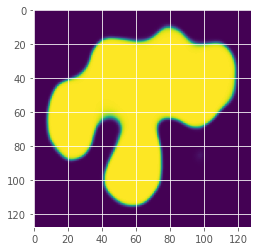

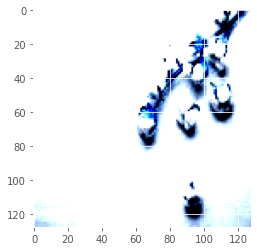

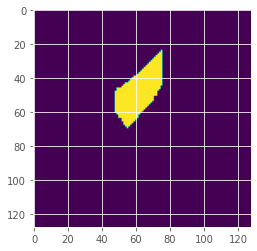

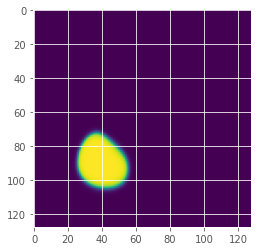

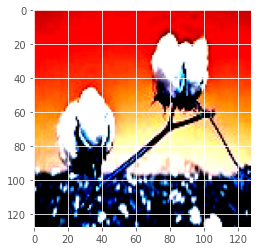

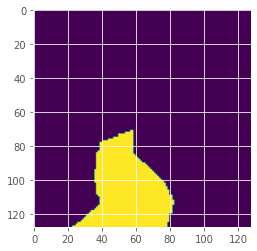

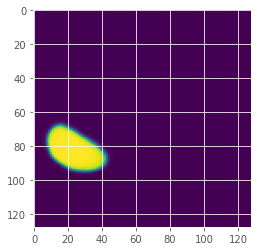

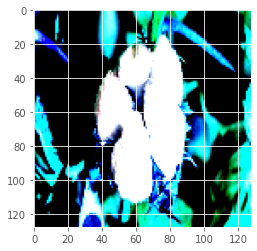

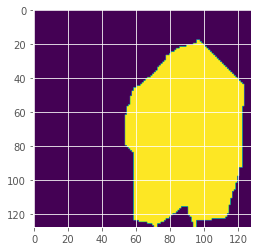

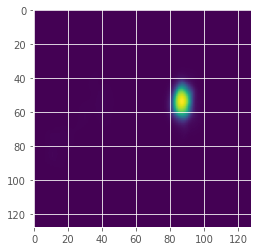

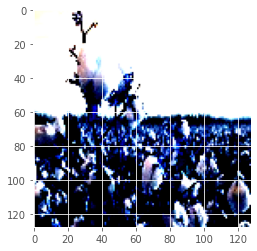

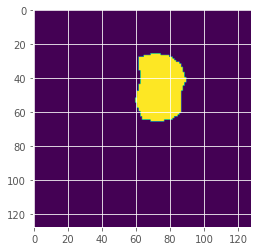

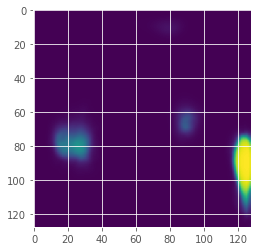

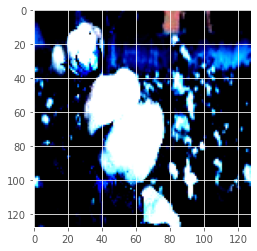

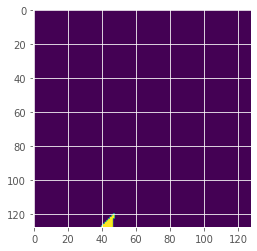

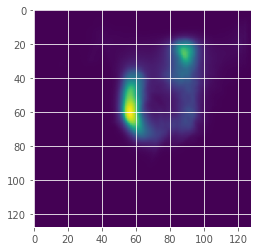

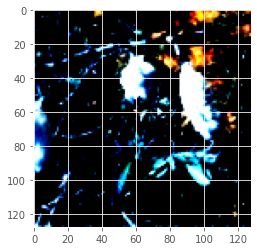

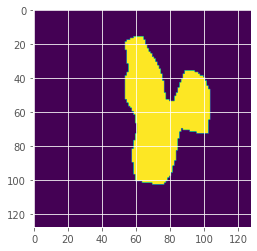

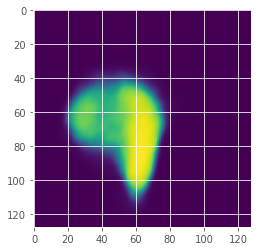

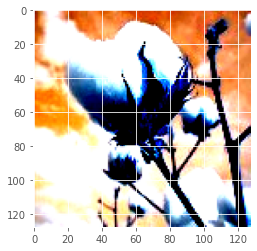

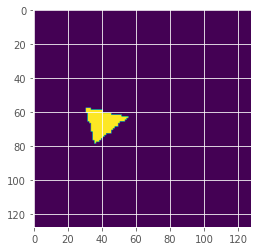

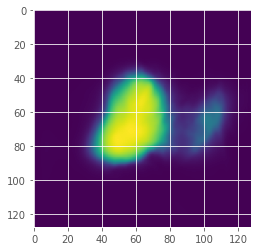

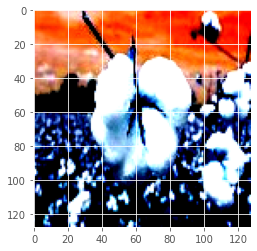

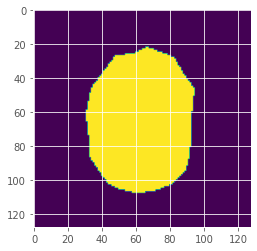

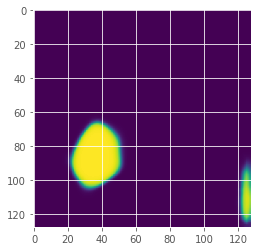

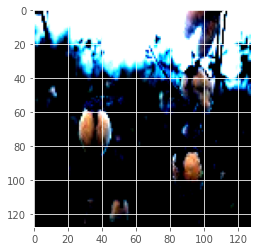

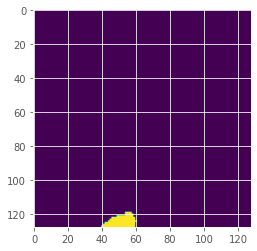

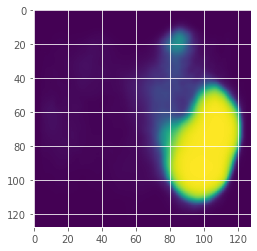

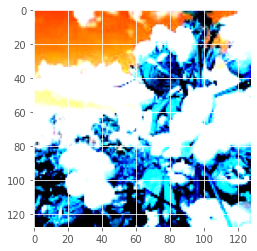

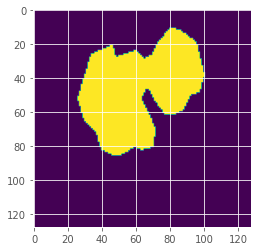

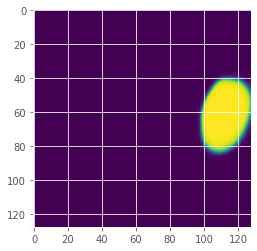

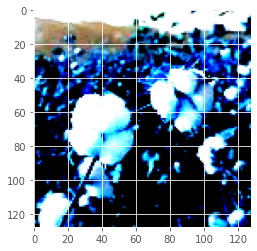

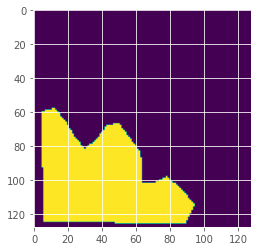

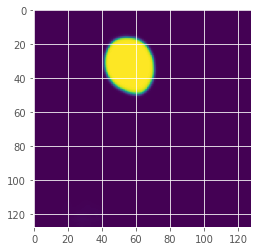

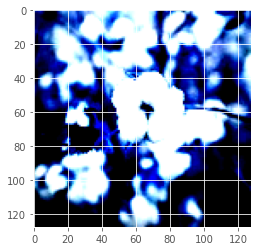

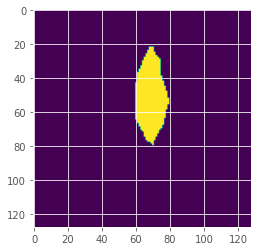

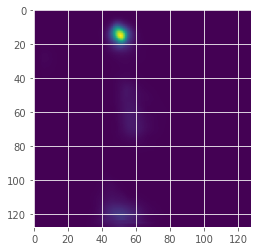

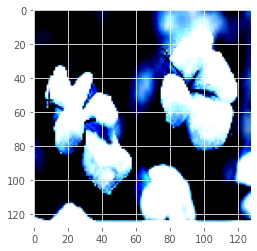

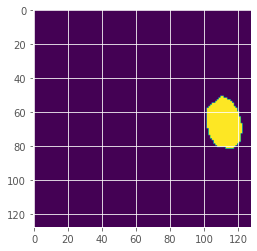

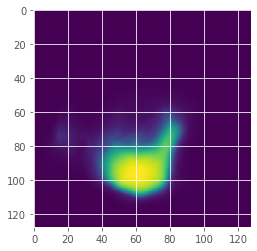

In [159]:
import numpy as np
for i in range(len(xval)):

  y=xval[[i],:,:,:]
  pred_mask = model.predict(y)
  plt.figure()
  plt.imshow(y[0,:,:,:])
  plt.figure()
  plt.imshow(yval[i,:,:,0])
  print(pred_mask,"fst")
  #pred_mask = tf.argmax(pred_mask, axis=1)
  #pred_mask = pred_mask[..., tf.newaxis]
  pred_mask
  import matplotlib.pyplot as plt
  plt.figure()
  #print(pred_mask)
  x=pred_mask[0,:,:,0]
  plt.imshow(x)

TypeError: ignored

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
model.save('model.h5')

In [ ]:
import numpy as np
pred_mask = model.predict(image)
pred_mask = tf.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[..., tf.newaxis]
pred_mask
import matplotlib.pyplot as plt
plt.figure()
x=pred_mask[1,:,:,0]/255
plt.imshow(x)

InvalidArgumentError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
def show_predictions():
      display( create_mask(pred_mask)])

In [ ]:
show_predictions()

[array([[[0.32941177, 0.5294118 , 0.4509804 ],
         [0.32156864, 0.52156866, 0.44313726],
         [0.33333334, 0.5254902 , 0.44705883],
         ...,
         [0.24313726, 0.45490196, 0.3647059 ],
         [0.24705882, 0.46666667, 0.3764706 ],
         [0.24313726, 0.4627451 , 0.37254903]],
 
        [[0.39215687, 0.58431375, 0.5058824 ],
         [0.38431373, 0.5764706 , 0.49803922],
         [0.38431373, 0.5764706 , 0.49803922],
         ...,
         [0.23529412, 0.45490196, 0.3647059 ],
         [0.2509804 , 0.47058824, 0.38039216],
         [0.24705882, 0.4745098 , 0.38039216]],
 
        [[0.42352942, 0.6039216 , 0.5294118 ],
         [0.42352942, 0.6039216 , 0.5294118 ],
         [0.42745098, 0.6039216 , 0.5294118 ],
         ...,
         [0.23529412, 0.45882353, 0.3764706 ],
         [0.25490198, 0.48235294, 0.3882353 ],
         [0.25490198, 0.49019608, 0.39607844]],
 
        ...,
 
        [[0.16470589, 0.1882353 , 0.41960785],
         [0.09803922, 0.1254902 , 0.31764

In [ ]:
import matplotlib.pyplot as plt
for i in show_predictions():
  image=i
  plt.figure()
  plt.imshow(image) 



[array([[[0.32941177, 0.5294118 , 0.4509804 ],
         [0.32156864, 0.52156866, 0.44313726],
         [0.33333334, 0.5254902 , 0.44705883],
         ...,
         [0.24313726, 0.45490196, 0.3647059 ],
         [0.24705882, 0.46666667, 0.3764706 ],
         [0.24313726, 0.4627451 , 0.37254903]],
 
        [[0.39215687, 0.58431375, 0.5058824 ],
         [0.38431373, 0.5764706 , 0.49803922],
         [0.38431373, 0.5764706 , 0.49803922],
         ...,
         [0.23529412, 0.45490196, 0.3647059 ],
         [0.2509804 , 0.47058824, 0.38039216],
         [0.24705882, 0.4745098 , 0.38039216]],
 
        [[0.42352942, 0.6039216 , 0.5294118 ],
         [0.42352942, 0.6039216 , 0.5294118 ],
         [0.42745098, 0.6039216 , 0.5294118 ],
         ...,
         [0.23529412, 0.45882353, 0.3764706 ],
         [0.25490198, 0.48235294, 0.3882353 ],
         [0.25490198, 0.49019608, 0.39607844]],
 
        ...,
 
        [[0.16470589, 0.1882353 , 0.41960785],
         [0.09803922, 0.1254902 , 0.31764

TypeError: ignored

In [ ]:
def show_predictions(dataset=None, num=1):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 128, 128, 3)


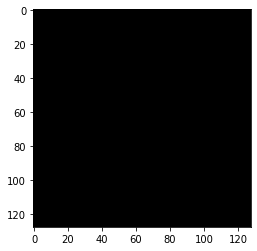

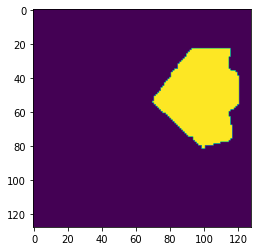

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
print(xtrain.shape)

plt.imshow([200, :, : , :]) 

plt.figure()

plt.imshow(ytrain[200, :, : ,0])